In [11]:
!pip install wandb
import wandb
wandb.login()
wandb.require("core")

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


# get the model

In [12]:
run = wandb.init(
    project="hutech_mushroom",
    job_type="test",
)
id = "resnet-model:v0"
artifact_model = run.use_artifact(
    f"hutech_mushroom/{id}",
    type="model",
)
airtifact_model_dir = artifact_model.download()

wandb:   1 of 1 files downloaded.  


In [13]:
print("Artifact downloaded to:", airtifact_model_dir)

Artifact downloaded to: /mnt/c/Users/beeha/VSCode/! - Self-study/All HUGE Projects/Computer Vision/hutech_mushroom/src/artifacts/resnet-model:v0


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import time
from tqdm import tqdm

import os
import wandb

# src function

## helper
from loader.loader import get_data_loader
from utils.metrics import compute_metrics
from utils.helper import load_config, get_model, get_optimizer, get_scheduler, EarlyStopping
from parsers.parser_train import parse_args

- inference on CPU

In [17]:
model = get_model("resnet", num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [19]:
model.load_state_dict(torch.load(os.path.join(airtifact_model_dir, "best-resnet-2025-03-29-12:23:00.pt")))

<All keys matched successfully>

- try a sample

3


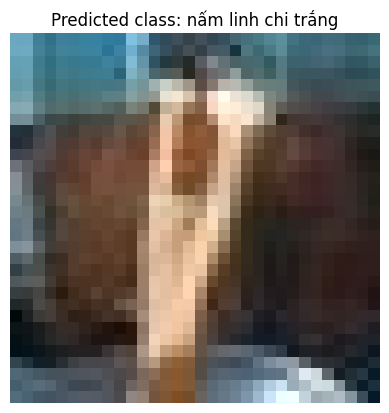

In [20]:
from PIL import Image
image_path = "../final_test/126.jpg"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

with torch.no_grad():
    image = Image.open(image_path)
    img_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    print(predicted.item())  # Print the predicted class index

classes = {
    0: "nấm mỡ",
    1: "nấm bào ngư",
    2: "nấm đùi gà",
    3: "nấm linh chi trắng",
}
# plot 
import matplotlib.pyplot as plt
import numpy as np
import cv2

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted class: {classes[predicted.item()]}")
plt.show()


- create .csv file

In [21]:
import os
import glob
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# classes' name
classes = {
    0: "nấm mỡ",
    1: "nấm bào ngư",
    2: "nấm đùi gà",
    3: "nấm linh chi trắng",
}

def predict(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

test_dir = "../final_test"
image_files = glob.glob(os.path.join(test_dir, "*.*"))

table = wandb.Table(columns=["image", "class"])

results = []
for image_path in image_files:
    image_id = os.path.basename(image_path).replace(".jpg", "")
    pred_class_idx = predict(image_path, model, transform, device)
    results.append({"id": image_id, "type": pred_class_idx}) 
    table.add_data(wandb.Image(image_path), classes[pred_class_idx])

# Create a DataFrame from the results and export to CSV
df = pd.DataFrame(results)
df.to_csv("kaggle_submission.csv", index=False)
print("Submission file saved as kaggle_submission.csv")
run = wandb.init(
    project="hutech_mushroom_submission",
    job_type="test",
)

# upload to wandb 
run.log({"table": table})

artifact = wandb.Artifact("submission", type="table")

Submission file saved as kaggle_submission.csv


In [22]:
artifact.add(table, "submission")
run.log_artifact(artifact)
artifact.wait()
print("Artifact uploaded to wandb")
run.finish()

Artifact uploaded to wandb
